<a href="https://colab.research.google.com/github/TOM-BOHN/MsDS-product-review-topic-modeling/blob/main/product_review_topic_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Product Review Topic Modeling
**Thomas Bohn**   --   **2023-09-18**

A report focused on modeling topics on text review data from Amazon for clothing and shoes manufactured by Nike. Use unsupervised clustering methods to create popular topics in the review data.

--  [Main Report](https://github.com/TOM-BOHN/MsDS-product-review-topic-modeling/blob/main/product_review_topic_modeling.ipynb)  --  [Github Repo](https://github.com/TOM-BOHN/MsDS-product-review-topic-modeling)  --  [Presentation Slides](tbd)  --  [Presentation Video](tbd) --

# 1.&nbsp;Introduction

## Setup Functions

### Import Python Libraries

The following python libraries are used in this notebook.

In [9]:
# Special Install of Packages
print('[-] Importing packages...')
#special_install_tmtoolkit
import os
try:
  import tmtoolkit
except:
  print('starting patch of tmtoolkit.')
  !pip install --quiet -U "tmtoolkit[recommended,lda,sklearn,wordclouds,textproc_extra,topic_modeling_eval_extra]"
  print('finished patch of tmtoolkit.')
  os.kill(os.getpid(), 9)

#special_install_matplotlib
import os
import matplotlib
if matplotlib.__version__ != "3.1.3":
    print('starting patch of matplotlib.')
    !pip uninstall --quiet -y matplotlib
    !pip install --quiet matplotlib==3.1.3
    print('finished patch of matplotlib.')
    os.kill(os.getpid(), 9)

#special_install_lda
import os
try:
  from tmtoolkit.topicmod.tm_lda import compute_models_parallel
except:
  !pip install --quiet tmtoolkit['lda']
  from tmtoolkit.topicmod.tm_lda import compute_models_parallel

try:
  from lda import LDA
except:
  !pip install --quiet lda
  from lda import LDA

#special_install_pyLDAvis
try:
  import pyLDAvis
except:
  !pip install --quiet pyLDAvis==2.1.2
  import pyLDAvis


[-] Importing packages...


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [48]:
print('[-] Importing packages...')
# File Connection and File Manipulation
import os
import pickle
import json
import glob
# Import Usability Functions
import logging
import warnings
# Basic Data Science Toolkits
import pandas as pd
import numpy as np
import math
import random
import time
from time import sleep
# Basic Data Vizualization
import seaborn as sns
import matplotlib.pyplot as plt
# Text Preprocessing (tmtoolkit)
import tmtoolkit
from tmtoolkit.corpus import Corpus, lemmatize, to_lowercase, remove_chars, filter_clean_tokens
from tmtoolkit.corpus import filter_for_pos, remove_common_tokens, remove_uncommon_tokens
from tmtoolkit.corpus import corpus_num_tokens, corpus_tokens_flattened
from tmtoolkit.corpus import doc_tokens, tokens_table, doc_labels, dtm
from tmtoolkit.corpus import vocabulary, vocabulary_size, vocabulary_counts
from tmtoolkit.topicmod.model_io import print_ldamodel_topic_words
from tmtoolkit.topicmod.tm_lda import compute_models_parallel
from tmtoolkit.corpus.visualize import plot_doc_lengths_hist, plot_doc_frequencies_hist, plot_ranked_vocab_counts
#https://tmtoolkit.readthedocs.io/en/latest/preprocessing.html
# Text Preprocessing(other)
from string import punctuation
import nltk
import scipy.sparse
# Topic Modeling
from lda import LDA
import pyLDAvis
from tmtoolkit.topicmod import tm_lda
from tmtoolkit.topicmod.tm_lda import compute_models_parallel
from tmtoolkit.topicmod.model_io import print_ldamodel_topic_words
from tmtoolkit.topicmod.model_io import save_ldamodel_to_pickle
from tmtoolkit.topicmod.model_io import load_ldamodel_from_pickle
from tmtoolkit.topicmod.model_io import ldamodel_top_doc_topics
from tmtoolkit.topicmod.evaluate import results_by_parameter
from tmtoolkit.topicmod.visualize import plot_eval_results
from tmtoolkit.topicmod.visualize import parameters_for_ldavis
from tmtoolkit.topicmod.visualize import generate_wordclouds_for_topic_words
from tmtoolkit.topicmod.model_stats import generate_topic_labels_from_top_words
from tmtoolkit.bow.bow_stats import doc_lengths

[-] Importing packages...


### Set Global Variables

In [3]:
random.seed(20191120)   # to make the sampling reproducible
np.set_printoptions(precision=5)

### Verify GPU Runtime

In [4]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

/bin/bash: line 1: nvidia-smi: command not found


In [5]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('  [.] Your runtime has {:.1f} gigabytes of available RAM'.format(ram_gb))

if ram_gb < 20:
  print('  [.] Not using a high-RAM runtime')
else:
  print('  [.] You are using a high-RAM runtime!')

  [.] Your runtime has 13.6 gigabytes of available RAM
  [.] Not using a high-RAM runtime


### Mount Google Drive

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Setup Directories

In [7]:
ROOT_DIR = "/content/drive/MyDrive/MSDS_marketing_text_analytics/master_files/2_topic_modeling"
DATA_DIR = "%s/data" % ROOT_DIR
EVAL_DIR = "%s/evaluation" % ROOT_DIR
MODEL_DIR = "%s/models" % ROOT_DIR

#Create missing directories, if they don't exist
if not os.path.exists(DATA_DIR):
  # Create a new directory because it does not exist
  os.makedirs(DATA_DIR)
  print("The data directory is created!")
if not os.path.exists(EVAL_DIR):
  # Create a new directory because it does not exist
  os.makedirs(EVAL_DIR)
  print("The evaluation directory is created!")
if not os.path.exists(MODEL_DIR):
  # Create a new directory because it does not exist
  os.makedirs(MODEL_DIR)
  print("The model directory is created!")

# 2.&nbsp;Data Source

## Copy Data From Source

In [ ]:
#!wget <URL> -P <COLAB PATH>
#source_url = 'http://128.138.93.164/meta_Clothing_Shoes_and_Jewelry.json.gz' # true source, need better link
source_url = 'https://docs.google.com/uc?export=download&id=12cPbdNpQ6Dmqg25Fb0kAxFSEug-8t3gc&confirm=t' # local source, working for testing
dest_path = '%s/meta_Clothing_Shoes_and_Jewelry.jsonl.gz' % DATA_DIR
!wget "$source_url" -O "$dest_path"


--2023-09-18 22:13:46--  https://docs.google.com/uc?export=download&id=12cPbdNpQ6Dmqg25Fb0kAxFSEug-8t3gc&confirm=t
Resolving docs.google.com (docs.google.com)... 108.177.126.138, 108.177.126.139, 108.177.126.113, ...
Connecting to docs.google.com (docs.google.com)|108.177.126.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0o-58-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/7qeuhp3jkprbc4o70snmnq820i7po11u/1695075225000/15741694635513001712/*/12cPbdNpQ6Dmqg25Fb0kAxFSEug-8t3gc?e=download&uuid=df5822a8-2268-40fd-a6f4-bb63239e6a05 [following]
--2023-09-18 22:13:47--  https://doc-0o-58-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/7qeuhp3jkprbc4o70snmnq820i7po11u/1695075225000/15741694635513001712/*/12cPbdNpQ6Dmqg25Fb0kAxFSEug-8t3gc?e=download&uuid=df5822a8-2268-40fd-a6f4-bb63239e6a05
Resolving doc-0o-58-docs.googleusercontent.com (doc-0o-58-docs.googleusercontent.com)... 142.251.18.1

In [ ]:
#!wget <URL> -P <COLAB PATH>
#source_url = 'http://128.138.93.164/reviews_Clothing_Shoes_and_Jewelry.json.gz' # true source, need better link
source_url = "https://docs.google.com/uc?export=download&id=12detwlesuD7S-O8i9w4LOii1DWML0i7Q&confirm=t" # local source, working for testing
dest_path = '%s/reviews_Clothing_Shoes_and_Jewelry.json.gz' % DATA_DIR
file_name = 'reviews_Clothing_Shoes_and_Jewelry.json.gz'
print(dest_path)
!wget "$source_url" -O "$dest_path"

/content/drive/MyDrive/MSDS_marketing_text_analytics/master_files/2_topic_modeling/data/reviews_Clothing_Shoes_and_Jewelry.json.gz
--2023-09-18 22:14:37--  https://docs.google.com/uc?export=download&id=12detwlesuD7S-O8i9w4LOii1DWML0i7Q&confirm=t
Resolving docs.google.com (docs.google.com)... 108.177.126.138, 108.177.126.102, 108.177.126.100, ...
Connecting to docs.google.com (docs.google.com)|108.177.126.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0o-58-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/bhu56oc1bj6feidn253emcrplo7110r7/1695075225000/15741694635513001712/*/12detwlesuD7S-O8i9w4LOii1DWML0i7Q?e=download&uuid=ba539796-3687-4d5a-b0d9-600b1016498d [following]
--2023-09-18 22:14:38--  https://doc-0o-58-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/bhu56oc1bj6feidn253emcrplo7110r7/1695075225000/15741694635513001712/*/12detwlesuD7S-O8i9w4LOii1DWML0i7Q?e=download&uuid=ba53979

In [ ]:
meta_file_path = '%s/meta_Clothing_Shoes_and_Jewelry.jsonl.gz' % DATA_DIR
review_file_path = '%s/reviews_Clothing_Shoes_and_Jewelry.json.gz' % DATA_DIR

!gzip -d "$meta_file_path"
!gzip -d "$review_file_path"

## Load the Product Data

In [ ]:
##this assigns the filename we're trying to load in to a string variable
meta_file_path = '%s/meta_Clothing_Shoes_and_Jewelry.jsonl' % DATA_DIR
loadedjson = open(meta_file_path, 'r')

In [ ]:
#The data used in this script comes from: http://jmcauley.ucsd.edu/data/amazon/links.html
#The data here is the 'per category' data for Clothing, Shoes and Jewelry
#use the above url to better understand the data, where it came from, and some
#tips on how to use it!

#getting reviews is going to be a two step process:
#1) go through the amazon product catalog for "Clothing, Shoes and Jewelery
#and extract out matching products by their ASIN
#2) go through the review data and parse out the matching reviews by ASIN

#1) - Extracting ASINs by brand
#First, let's iterate through the data and store it as a python dictionary

#let's set a counter to see how many products we have in the json
count = 0
start_time = time.time()
#loading the json file
#we've always got to initiate dictionaries before we can use them
allproducts = {}

#each line of data here is a product and its metadata
print('loading product data to dictionary:')
for aline in loadedjson:
    #creating a counter to know our progress in processing the entire catalog
    count += 1
    if count % 100000 == 0:
        #we're only going to print our count every 100k, this way we don't spam
        #our output console
        current_runtime = round(time.time() - start_time,3)
        print('[-] current progress:', count, 'and a runtime of', current_runtime, 'seconds.')
    #interestingly enough, this data isn't true JSON, instead it's python
    #dictionaries that have essentially been printed as text. It's odd, but if
    #we read the documentaion, all we need to do to load a dictionary is use
    #the eval function. https://www.programiz.com/python-programming/methods/built-in/eval
    #eval takes whatever string is passed to it, and interprets it as python code
    #and runs it. So here, it's exactly what we need to interpret a printed
    #python dictionary

    aproduct = eval(aline)

    #making a dictionary entry with the ASIN of the product as the key
    #and it's metadata as nested dictionaries
    allproducts[aproduct['asin']] = aproduct

loading product data to dictionary:
[-] current progress: 100000 and a runtime of 14.454 seconds.
[-] current progress: 200000 and a runtime of 29.4 seconds.
[-] current progress: 300000 and a runtime of 45.329 seconds.
[-] current progress: 400000 and a runtime of 63.058 seconds.
[-] current progress: 500000 and a runtime of 79.572 seconds.
[-] current progress: 600000 and a runtime of 95.584 seconds.
[-] current progress: 700000 and a runtime of 113.943 seconds.
[-] current progress: 800000 and a runtime of 134.295 seconds.
[-] current progress: 900000 and a runtime of 152.333 seconds.
[-] current progress: 1000000 and a runtime of 171.838 seconds.
[-] current progress: 1100000 and a runtime of 192.491 seconds.
[-] current progress: 1200000 and a runtime of 211.064 seconds.
[-] current progress: 1300000 and a runtime of 235.86 seconds.
[-] current progress: 1400000 and a runtime of 255.625 seconds.
[-] current progress: 1500000 and a runtime of 276.365 seconds.


In [ ]:
#print a summary of the records processed
allproducts_length = len(allproducts)
current_runtime = round(time.time() - start_time,3)
print('Process completed for', count, 'of', allproducts_length, 'records with a final runtime of', current_runtime, 'seconds.')

Process completed for 1503384 of 1503384 records with a final runtime of 277.317 seconds.


## Summarize the Product Categories

In [ ]:
#Next we need to explore the product data to see what categories are common in the
#data. As you'll learn, product categories are wishywashy in that they can be
#product categories (e.g., baby, house and home), or they can be brands!
#We're already dealing with a subset of the product categories, Clothing, Shoes
#and Jewlery. We still need to find a list of product ids for our specific
#brand. To do this,We're going to use the 'categories' metadata field to find
#your brand

##Let's create a dictionary of all the product subcategories
#and by doing so, also come up with a list of brands and the number of products
#they have listed in the amazon product catalog

allcategories = {}
count = 0
start_time = time.time()

#each line of data here is a product and its metadata
print('loading categories data to dictionary:')
for aproduct in allproducts:
    #creating a counter to know our progress in processing the entire catalog
    count += 1
    if count % 100000 == 0:
        #we now know there are 1.5 million products, so we can build a counter
        #that tells how our processing is going. When the counter reaches one
        #we're done!
        current_progress = int(round(count/allproducts_length,2)*100)
        current_runtime = round(time.time() - start_time,3)
        print('[-] current progress:', current_progress, '%', 'and a runtime of', current_runtime, 'seconds.')

    #setting a dict up with just one product, so we can inspect and ref it
    aproduct = allproducts[aproduct]
    #creating a dictionary entry for each product category
    #also counting the occurances of each category
    if 'categories' in aproduct:
        for categories in aproduct['categories']:
            for acategory in categories:
                if acategory in allcategories:
                    allcategories[acategory] += 1
                if acategory not in allcategories:
                    allcategories[acategory] = 1

loading categories data to dictionary:
[-] current progress: 7 % and a runtime of 0.801 seconds.
[-] current progress: 13 % and a runtime of 1.545 seconds.
[-] current progress: 20 % and a runtime of 2.029 seconds.
[-] current progress: 27 % and a runtime of 2.492 seconds.
[-] current progress: 33 % and a runtime of 2.947 seconds.
[-] current progress: 40 % and a runtime of 3.423 seconds.
[-] current progress: 47 % and a runtime of 3.853 seconds.
[-] current progress: 53 % and a runtime of 4.283 seconds.
[-] current progress: 60 % and a runtime of 4.722 seconds.
[-] current progress: 67 % and a runtime of 5.135 seconds.
[-] current progress: 73 % and a runtime of 5.583 seconds.
[-] current progress: 80 % and a runtime of 5.983 seconds.
[-] current progress: 86 % and a runtime of 6.392 seconds.
[-] current progress: 93 % and a runtime of 6.81 seconds.
[-] current progress: 100 % and a runtime of 7.197 seconds.


In [ ]:
#print a summary of the categories processed
allcategories_length = len(allcategories)
current_runtime = round(time.time() - start_time,3)
print('Process completed for', allcategories_length, 'categories with a final runtime of', current_runtime, 'seconds.')

Process completed for 2773 catregories with a final runtime of 7.224 seconds.


In [ ]:
#create a sorted list of categories
sortedlist = []
#covert the dictionary to a list of tuples
for acategory in allcategories:
  sortedlist.append((allcategories[acategory],acategory))
#sort the list
sortedlist = sorted(sortedlist, reverse=True)
#print the top x records in the list
top_n = 20
for item in range(0,top_n):
  print('[',str(item).zfill(2),']', sortedlist[item])

[ 00 ] (3429257, 'Clothing, Shoes & Jewelry')
[ 01 ] (1086181, 'Women')
[ 02 ] (617092, 'Clothing')
[ 03 ] (541681, 'Men')
[ 04 ] (537761, 'Novelty, Costumes & More')
[ 05 ] (432653, 'Shoes')
[ 06 ] (339900, 'Novelty')
[ 07 ] (268065, 'Shoes & Accessories: International Shipping Available')
[ 08 ] (255454, 'Jewelry')
[ 09 ] (174962, 'Accessories')
[ 10 ] (97095, 'Girls')
[ 11 ] (93596, 'Tops & Tees')
[ 12 ] (87688, 'Dresses')
[ 13 ] (84549, 'T-Shirts')
[ 14 ] (82063, 'Boots')
[ 15 ] (80302, 'Shirts')
[ 16 ] (79897, 'Sandals')
[ 17 ] (79545, 'Watches')
[ 18 ] (77684, 'Boys')
[ 19 ] (73507, 'Jewelry: International Shipping Available')


In [ ]:
nike_categories = allcategories['Nike']
print(nike_categories, 'product records for Nike.')

8327 product records for Nike.


## Extract a List of Product Ids

In [ ]:
#Now, go ahead and use the Variable Expolorer in Spyder to locate a brand
#that has a lot of product entries! Alternatively, type allcategories['Brand name']
#to get a count for a specific brand. For instance:
#>>allcategories['Nike']
#>> 8327
#>>allcategories['adidas']
#>> 8645

#I'd reccommend at least 1.5k products, but you're welcome to try smaller counts
#all I care about is whether you have at least 2k reviews when it's all said and done


##Now we need to go through our newly first dictionary and extract out the
##matching ASINs for Nike

##First, create a set where we will store our ASINs
##We choose a set here because we don't want duplicates
allnikeasins = set()
count = 0
start_time = time.time()

for areview in allproducts:
    theproduct = allproducts[areview]
    count += 1
    if count % 100000 == 0:
        current_progress = int(round(count/allproducts_length,2)*100)
        current_runtime = round(time.time() - start_time,3)
        print('[-] current progress:', current_progress, '%', 'and a runtime of', current_runtime, 'seconds.')

    #let's iterate fore each category for a product, again, any given product
    #can be assigned multiple product categories,
    for categories in theproduct['categories']:
        #each category is actually encoded as a list (even though they should
        #just be strings, so we need to iterate one more time)
        for acategory in categories:
            #checking to see if the product category matches Nike
            #lowercasing the category string incase capitalization might get
            #in the way of a match
            if 'nike' in acategory.lower():
                #let's go ahead and store it to our set of Nike ASINs
                allnikeasins.add(theproduct['asin'])

[-] current progress: 7 % and a runtime of 0.311 seconds.
[-] current progress: 13 % and a runtime of 0.61 seconds.
[-] current progress: 20 % and a runtime of 0.932 seconds.
[-] current progress: 27 % and a runtime of 1.244 seconds.
[-] current progress: 33 % and a runtime of 1.558 seconds.
[-] current progress: 40 % and a runtime of 1.858 seconds.
[-] current progress: 47 % and a runtime of 2.165 seconds.
[-] current progress: 53 % and a runtime of 2.471 seconds.
[-] current progress: 60 % and a runtime of 2.753 seconds.
[-] current progress: 67 % and a runtime of 3.037 seconds.
[-] current progress: 73 % and a runtime of 3.338 seconds.
[-] current progress: 80 % and a runtime of 3.63 seconds.
[-] current progress: 86 % and a runtime of 3.911 seconds.
[-] current progress: 93 % and a runtime of 4.201 seconds.
[-] current progress: 100 % and a runtime of 4.649 seconds.


In [ ]:
#print a summary of the categories processed
allnikeasins_length = len(allnikeasins)
current_runtime = round(time.time() - start_time,3)
print('Process completed for', allnikeasins_length, 'records with a final runtime of', current_runtime, 'seconds.')

Process completed for 8327 records with a final runtime of 4.684 seconds.


In [ ]:
# write the ASINs out to a file as a checkpoint
outputfile = open('%s/allasins.txt' % DATA_DIR, 'w')

outputfile.write(','.join(allnikeasins))
outputfile.close()

## Load the Review Data

In [16]:
#this assigns the filename we're trying to load in to a string variable
review_file_path = '%s/reviews_Clothing_Shoes_and_Jewelry.json' % DATA_DIR
loadedjson = open(review_file_path, 'r')

In [17]:
#2) - Parsing the review data
#First, let's iterate through the data and store it as a python dictionary

#let's set a counter to see how many products we have in the json
count = 0
start_time = time.time()
#loading the json file
#we've always got to initiate dictionaries before we can use them
allreviews = {}

#each line of data here is a product and its metadata
print('loading review data to dictionary:')
for aline in loadedjson:
    #creating a counter to know our progress in processing the entire catalog
    count += 1
    if count % 500000 == 0:
        #we're only going to print our count every 100k, this way we don't spam
        #our output console
        current_runtime = round(time.time() - start_time,3)
        print('[-] current progress:', count, 'and a runtime of', current_runtime, 'seconds.')
    #interestingly enough, this data isn't true JSON, instead it's python
    #dictionaries that have essentially been printed as text. It's odd, but if
    #we read the documentaion, all we need to do to load a dictionary is use
    #the eval function. https://www.programiz.com/python-programming/methods/built-in/eval
    #eval takes whatever string is passed to it, and interprets it as python code
    #and runs it. So here, it's exactly what we need to interpret a printed
    #python dictionary

    areview = eval(aline)

    #making a dictionary entry with the iteration count as the review key
    #and it's metadata as nested dictionaries
    allreviews[count] = areview
print('completed load of review data to dictionary.')

loading review data to dictionary:
[-] current progress: 500000 and a runtime of 36.032 seconds.
[-] current progress: 1000000 and a runtime of 68.749 seconds.
[-] current progress: 1500000 and a runtime of 101.409 seconds.
[-] current progress: 2000000 and a runtime of 132.848 seconds.
[-] current progress: 2500000 and a runtime of 165.368 seconds.
[-] current progress: 3000000 and a runtime of 199.647 seconds.
[-] current progress: 3500000 and a runtime of 236.8 seconds.
[-] current progress: 4000000 and a runtime of 275.601 seconds.
[-] current progress: 4500000 and a runtime of 308.862 seconds.
[-] current progress: 5000000 and a runtime of 343.602 seconds.
[-] current progress: 5500000 and a runtime of 372.095 seconds.


In [18]:
#print a summary of the records processed
allreviews_length = len(allreviews)
current_runtime = round(time.time() - start_time,3)
print('Process completed for', count, 'of', allreviews_length, 'records with a final runtime of', current_runtime, 'seconds.')

Process completed for 5748920 of 5748920 records with a final runtime of 417.348 seconds.


## Extract a List of Reviews Related to the Product Ids

In [19]:
#Load the list of Nike Asins

allnikeasins = []
allasins_file_path = '%s/allasins.txt' % DATA_DIR

#open the file and load to a list
for data in open(allasins_file_path, 'r'):
  asins = data.split(',')
  for anasin in asins:
    allnikeasins.append(anasin)

In [21]:
#print a summary of the records processed
allnikeasins_length = len(allnikeasins)
print('Process completed for', allnikeasins_length, 'records.')
print('First 5 Asins in list:', allnikeasins[0:5])

Process completed for 8327 records.
First 5 Asins in list: ['B00DT6VLOQ', 'B001LQK6L0', 'B00ANBSBDY', 'B00AQL3UDW', 'B004TU1VV4']


In [22]:
#Now, we need to go through all the reviews and pick out the reviews that
#correspond to the matching ASINs, that is reviews that are tied to Nike ASINs

#let's set a counter to see how many products we have in the json
count = 0
start_time = time.time()
#loading the json file
#we've always got to initiate dictionaries before we can use them
nikereviews = {}

#each line of data here is a product and its metadata
print('loading review data to dictionary:')
for areview in allreviews:
  count += 1
  if count % 500000 == 0:
      current_progress = int(round(count/allreviews_length,2)*100)
      current_runtime = round(time.time() - start_time,3)
      print('[-] current progress:', current_progress, '%', 'and a runtime of', current_runtime, 'seconds.')
  #setting current review as a dictionary, so we can easily reference its
  #entries
  thereview = allreviews[areview]
  theasin = thereview['asin']
  reviewerid = thereview['reviewerID']
  if theasin in allnikeasins:
      #im setting the key here as something unique. if we just did by asin
      #we'd only have one review for each asin, with the last review the only
      #one being stored
      thekey = '%s.%s' % (theasin, reviewerid)
      nikereviews[thekey] = thereview
print('completed load of review data to dictionary.')

loading review data to dictionary:
[-] current progress: 9 % and a runtime of 95.051 seconds.
[-] current progress: 17 % and a runtime of 188.805 seconds.
[-] current progress: 26 % and a runtime of 281.424 seconds.
[-] current progress: 35 % and a runtime of 374.236 seconds.
[-] current progress: 43 % and a runtime of 466.713 seconds.
[-] current progress: 52 % and a runtime of 559.326 seconds.
[-] current progress: 61 % and a runtime of 654.168 seconds.
[-] current progress: 70 % and a runtime of 747.421 seconds.
[-] current progress: 78 % and a runtime of 840.299 seconds.
[-] current progress: 87 % and a runtime of 933.018 seconds.
[-] current progress: 96 % and a runtime of 1025.682 seconds.
completed load of review data to dictionary.


In [23]:
#print a summary of the records processed
nikereviews_length = len(nikereviews)
current_runtime = round(time.time() - start_time,3)
print('Process completed for', count, 'of', nikereviews_length, 'records with a final runtime of', current_runtime, 'seconds.')

Process completed for 5748920 of 21570 records with a final runtime of 1077.421 seconds.


In [24]:
#save our data to a JSON dictionary
allnikereviews_file_path = '%s/allnikereviews.json' % DATA_DIR
json.dump(nikereviews, open(allnikereviews_file_path, 'w'))

## Preview a Record from the File

In [25]:
#this assigns the filename we're trying to load
allnikereviews_file_path = '%s/allnikereviews.json' % DATA_DIR
json_file = json.load(open(allnikereviews_file_path, 'r'))

In [27]:
#select a random review
count = 0
for a_review in json_file:
  count += 1
  if count % 1000 == 0:
    the_review = json_file[a_review]
    print(the_review)
    #sleep(10)
  if count >= 10000:
    break

{'reviewerID': 'A7H6Q3JAE3UTR', 'asin': 'B000G42Z2Q', 'reviewerName': 'april fritsche', 'helpful': [0, 0], 'reviewText': 'I bought these for my son and he loves them.  He said that that r very comfortable.  He said he wears them all the time.  He said that they look great.', 'overall': 5.0, 'summary': 'love them', 'unixReviewTime': 1388620800, 'reviewTime': '01 2, 2014'}
{'reviewerID': 'A278R123DX0CLR', 'asin': 'B0013UXIAK', 'reviewerName': 'AQB', 'helpful': [0, 2], 'reviewText': 'Too much money for the pair. I saw a better pair for less price. I will shop around Zappos or Nike websites next time.', 'overall': 3.0, 'summary': 'its ok', 'unixReviewTime': 1377561600, 'reviewTime': '08 27, 2013'}
{'reviewerID': 'A1CZIWT35UVJS6', 'asin': 'B001PA87L8', 'reviewerName': 'Courtney', 'helpful': [1, 1], 'reviewText': "I love these shoes, they are perfect. Very comfy especially since I'm on my feet all day at work. It's wierd that they don't have a tongue but it only makes them fit better.", 'ove

In [28]:
#print the review to the screen
the_review

{'reviewerID': 'AGP3D5ZB7N3NA',
 'asin': 'B00594DYW8',
 'reviewerName': 'S. M. Hughes "mom of 2"',
 'helpful': [0, 0],
 'reviewText': 'I absolutely love this pair of shoes. I am more prone to barefoot running, and the flexibility of these shoes are not at all restrictive on my feet and they feel great! I was so very happy to find them for a good price! Seller shipped very quickly and overall, the experience with this purchase was A+!',
 'overall': 5.0,
 'summary': 'Great Item, great seller!',
 'unixReviewTime': 1322524800,
 'reviewTime': '11 29, 2011'}

# 3.&nbsp;Preprocessing the Data

## Load the Nike Review Data

In [23]:
#this assigns the filename we're trying to load
allnikereviews_file_path = '%s/allnikereviews.json' % DATA_DIR
json_file = json.load(open(allnikereviews_file_path, 'r'))

In [24]:
#extract review text from all review details
reviews = []
for a_review in json_file:
    the_review = json_file[a_review]
    text = the_review["reviewText"]
    reviews.append(text)
#create a corpus of the nike reviews
corpus = Corpus({ i:r for i, r in enumerate(reviews)}, language='en')

In [25]:
#print the length of the corpus
corpus_length = len(corpus)
print('Length of the Corpus:', corpus_length)

Length of the Corpus: 21570


In [26]:
#print a random corpus
k = 91
print('record for key', k, 'contains:')
print(corpus[k])

record for key 91 contains:
Document "91" (102 tokens, 9 token attributes, 2 document attributes)


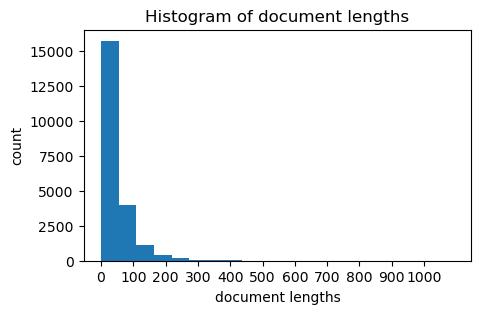

In [27]:
#view a histogram of document lengths
fig, ax = plt.subplots(figsize=(5, 3))   # make the plot larger
plot_doc_lengths_hist(fig, ax, corpus, y_log=False, bins=20)  # use 20 bins
ax.set_xticks(range(0, 1001, 100))    # set x axis ticks and range
plt.show()

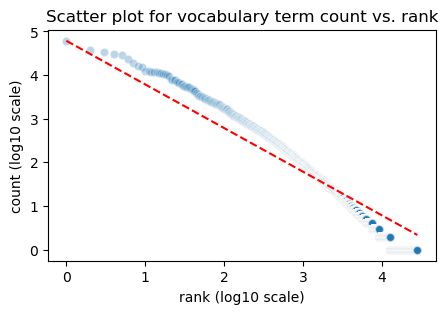

In [28]:
#rank-frequency distribution plot for token frequencies
fig, ax = plt.subplots(figsize=(5, 3))
plot_ranked_vocab_counts(fig, ax, corpus, zipf=True)
plt.show();

In [29]:
#save the files to disk
corpus_file_path = '%s/corpus_source.p' % DATA_DIR
pickle.dump(corpus, open(corpus_file_path, 'wb') )

## Preprocess Text Data

In [15]:
#location of corpus files
corpus_file_path = '%s/corpus_source.p' % DATA_DIR
#load the corpus
corpus = pickle.load(open(corpus_file_path, 'rb'))

In [16]:
#print a random corpus
k = 91
print('record for key', k, 'contains:')
print(corpus[k])

record for key 91 contains:
Document "91" (102 tokens, 9 token attributes, 2 document attributes)


In [17]:
####create an english pre-processor
####preproc = TMPreproc(corpus, language='en')
####tag the words with parts of speach
####preproc.pos_tag()
# lemmatize the words (convert to root base)
lemmatize(corpus, inplace=True)
# convert words to lowercase
to_lowercase(corpus, inplace=True)
# remove special charecters
#####preproc.remove_special_chars_in_tokens()
remove_chars(corpus, chars=punctuation, inplace=True)
# add custom stopwords to remove for urls and not
####preproc.add_stopwords(['http', 'nt'])       #####
filter_clean_tokens(corpus, remove_stopwords=True, inplace=True)
# limit words to nouns, verbs, and adjectives
filter_for_pos(corpus, search_pos=['N', 'V', 'ADJ'], inplace=True)
# remove numbers and any word shorter than 2 characters
filter_clean_tokens(corpus, remove_numbers=True, inplace=True)
filter_clean_tokens(corpus, remove_shorter_than=2, inplace=True)
# remove tokens that are fairly common
remove_common_tokens(corpus, df_threshold=0.8, inplace=True)
# remove tokens that are extreamly rare
remove_uncommon_tokens(corpus, df_threshold=0.01, inplace=True)

## Review Preprocessing of Text

In [18]:
#create a summary of a sample
def preview_sample_review(corpus, k = 0):
  samp_texty = corpus[k]
  tok = doc_tokens(corpus, with_attr=True)
  samp_token_list = tok[k]['token']
  samp_token_list_length = len(samp_token_list)

  #print a random corpus
  print('record for key', k, 'contains:')
  print(corpus[k])
  print('the text contains', samp_token_list_length, 'tokens.')
  print('sample token list:', samp_token_list[0:10])
  print()

In [19]:
preview_sample_review(corpus, k = 91)
preview_sample_review(corpus, k = 1)
preview_sample_review(corpus, k = 2000)

record for key 91 contains:
Document "91" (17 tokens, 9 token attributes, 2 document attributes)
the text contains 17 tokens.
sample token list: ['watch', 'buy', 'find', 'nike', 'get', 'small', 'woman', 'pay', 'man', 'product']

record for key 1 contains:
Document "1" (7 tokens, 9 token attributes, 2 document attributes)
the text contains 7 tokens.
sample token list: ['cute', 'fit', 'small', 'wrist', 'wear', 'love', 'watch']

record for key 2000 contains:
Document "2000" (8 tokens, 9 token attributes, 2 document attributes)
the text contains 8 tokens.
sample token list: ['great', 'shoe', 'fit', 'comfortable', 'shoe', 'recommend', 'awesome', 'price']



In [20]:
#create a summary of the preprocess
n = 5
vocab_size = vocabulary_size(corpus)
tokens_table = tokens_table(corpus)
#print a summary of the preprocess
print('corpus vocabulary size:', vocab_size)
print('first', n, 'rows of tokens table:')
print(tokens_table.head(5))

corpus vocabulary size: 245
first 5 rows of tokens table:
   doc  position     token  is_punct  is_stop     lemma  like_num   pos  tag
0    0         0   receive     False    False   receive     False  VERB  VBD
1    0         1      blue     False    False      blue     False   ADJ   JJ
2    0         2      show     False    False      show     False  VERB  VBN
3    0         3    change     False    False    change     False  VERB  VBP
4    0         4  daughter     False    False  daughter     False  NOUN   NN


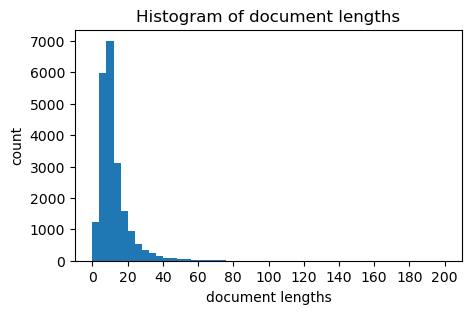

In [21]:
#view a histogram of document lengths
fig, ax = plt.subplots(figsize=(5, 3))   # make the plot larger
plot_doc_lengths_hist(fig, ax, corpus, y_log=False, bins=50)  # use 20 bins
ax.set_xticks(range(0, 201, 20))    # set x axis ticks and range
plt.show()

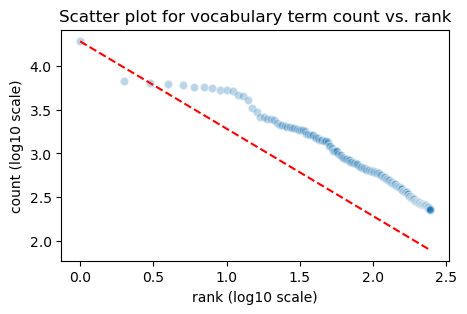

In [22]:
#rank-frequency distribution plot for token frequencies
fig, ax = plt.subplots(figsize=(5, 3))
plot_ranked_vocab_counts(fig, ax, corpus, zipf=True)
plt.show();

## Save the Preprocessed Data

In [23]:
#create the document labels
doc_lbls = np.array(doc_labels(corpus))
#preview the document labels
print(doc_lbls[:10])

[0 1 2 3 4 5 6 7 8 9]


In [24]:
#create the vocabulary
vocab = np.array(vocabulary(corpus))
#preview the document labels
print(vocab[:10])

['able' 'air' 'amazing' 'amazon' 'ankle' 'arch' 'area' 'arrive' 'ask'
 'awesome']


In [25]:
#create the document-term matrix (DTM)
dtm_main = dtm(corpus)
#dtm_main = scipy.sparse.csr_matrix(dtm_main)
#preview the dtm
dtm_main

<21570x245 sparse matrix of type '<class 'numpy.int32'>'
	with 212452 stored elements in Compressed Sparse Row format>

In [26]:
#save the files to disk
corpus_file_path = '%s/corpus.p' % DATA_DIR
doc_labels_file_path = '%s/doc_labels.p' % DATA_DIR
vocab_file_path = '%s/vocab.p' % DATA_DIR
dtm_file_path = '%s/dtm_main.npz' % DATA_DIR

pickle.dump(corpus, open(corpus_file_path, 'wb') )
pickle.dump(doc_lbls, open(doc_labels_file_path, 'wb'))
pickle.dump(vocab, open(vocab_file_path, 'wb'))
scipy.sparse.save_npz(dtm_file_path, dtm_main)

# 4.&nbsp;Model: Parameter Tuning

## Import the Corpus

In [11]:
#location of corpus files
corpus_file_path = '%s/corpus.p' % DATA_DIR
doc_labels_file_path = '%s/doc_labels.p' % DATA_DIR
vocab_file_path = '%s/vocab.p' % DATA_DIR
dtm_file_path = '%s/dtm_main.npz' % DATA_DIR

#load the corpus
corpus = pickle.load(open(corpus_file_path, 'rb'))
doc_lbls = pickle.load(open(doc_labels_file_path, 'rb'))
dtm_main = scipy.sparse.load_npz(dtm_file_path)
vocab = pickle.load(open(vocab_file_path, 'rb'))

#preview the document labels
print(doc_lbls[:10])
print(vocab[:10])
dtm_main

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[0 1 2 3 4 5 6 7 8 9]
['able' 'air' 'amazing' 'amazon' 'ankle' 'arch' 'area' 'arrive' 'ask'
 'awesome']


<21570x245 sparse matrix of type '<class 'numpy.int32'>'
	with 212452 stored elements in Compressed Sparse Row format>

In [12]:
# suppress the "INFO" messages and warnings from lda
logger = logging.getLogger('lda')
logger.addHandler(logging.NullHandler())
logger.propagate = False
warnings.filterwarnings('ignore')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Evaluate Model Options

In [45]:
#setup parameters
const_params = {'n_iter': 500,'eta': 0.1, 'random_state': 20191122  }
ks = list(range(10, 100, 10)) + list(range(100, 201, 20))
varying_params = [dict(n_topics=k, alpha=round(1/k, 4)) for k in ks]
num_trials = len(varying_params)
#display the parameter selections
print('constant parameters:', const_params)
print('number of topics to try:', ks)
print('number of trials:', ks)
print('variable parameter trials:', varying_params)

constant parameters: {'n_iter': 500, 'eta': 0.1, 'random_state': 20191122}
number of topics to try: [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 120, 140, 160, 180, 200]
number of trials: [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 120, 140, 160, 180, 200]
variable parameter trials: [{'n_topics': 10, 'alpha': 0.1}, {'n_topics': 20, 'alpha': 0.05}, {'n_topics': 30, 'alpha': 0.0333}, {'n_topics': 40, 'alpha': 0.025}, {'n_topics': 50, 'alpha': 0.02}, {'n_topics': 60, 'alpha': 0.0167}, {'n_topics': 70, 'alpha': 0.0143}, {'n_topics': 80, 'alpha': 0.0125}, {'n_topics': 90, 'alpha': 0.0111}, {'n_topics': 100, 'alpha': 0.01}, {'n_topics': 120, 'alpha': 0.0083}, {'n_topics': 140, 'alpha': 0.0071}, {'n_topics': 160, 'alpha': 0.0063}, {'n_topics': 180, 'alpha': 0.0056}, {'n_topics': 200, 'alpha': 0.005}]


In [46]:
#evaluate model results
eval_results = tm_lda.evaluate_topic_models(dtm_main,
                                            varying_parameters = varying_params,
                                            constant_parameters = const_params,
                                            metric = ['arun_2010','cao_juan_2009','coherence_mimno_2011']
                                            )
results_by_n_topics = results_by_parameter(eval_results, 'n_topics')
results_by_n_topics = [(x, {key: round(value, 3) for key, value in inner_dict.items()}) for x, inner_dict in results_by_n_topics]
#display the results of the models as text
print('results by n topic models:', results_by_n_topics)

results by n topic models: [(10, {'arun_2010': 0.141, 'cao_juan_2009': 0.443, 'coherence_mimno_2011': -417.351}), (20, {'arun_2010': 0.187, 'cao_juan_2009': 0.401, 'coherence_mimno_2011': -412.594}), (30, {'arun_2010': 0.249, 'cao_juan_2009': 0.37, 'coherence_mimno_2011': -426.802}), (40, {'arun_2010': 0.29, 'cao_juan_2009': 0.356, 'coherence_mimno_2011': -425.949}), (50, {'arun_2010': 0.346, 'cao_juan_2009': 0.339, 'coherence_mimno_2011': -439.717}), (60, {'arun_2010': 0.419, 'cao_juan_2009': 0.336, 'coherence_mimno_2011': -440.296}), (70, {'arun_2010': 0.434, 'cao_juan_2009': 0.328, 'coherence_mimno_2011': -448.58}), (80, {'arun_2010': 0.482, 'cao_juan_2009': 0.322, 'coherence_mimno_2011': -446.482}), (90, {'arun_2010': 0.543, 'cao_juan_2009': 0.315, 'coherence_mimno_2011': -445.246}), (100, {'arun_2010': 0.554, 'cao_juan_2009': 0.316, 'coherence_mimno_2011': -449.502}), (120, {'arun_2010': 0.593, 'cao_juan_2009': 0.301, 'coherence_mimno_2011': -454.648}), (140, {'arun_2010': 0.656, 

In [44]:
# plot the results of the model trials
#plot_eval_results(eval_results = results_by_n_topics, figsize=(8, 6))
#I cannot get this function to work for the life of me
#package conflict with version of pyplot

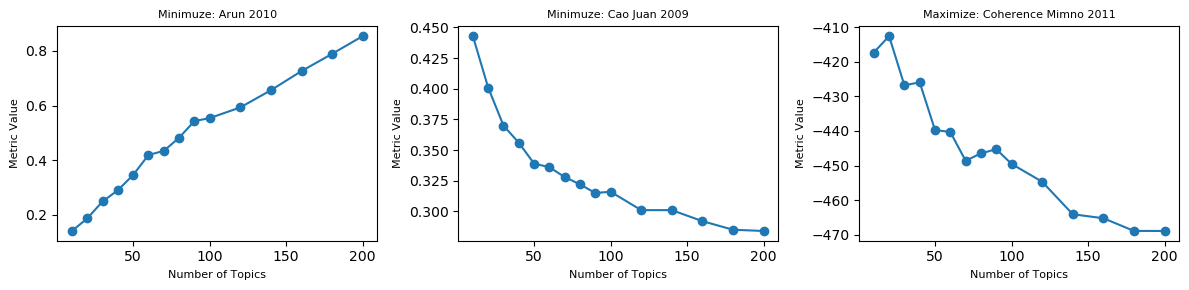

In [47]:
# Extract data from results_by_n_topics
n_topics = [item[0] for item in results_by_n_topics]
arun_2010_values = [item[1]['arun_2010'] for item in results_by_n_topics]
cao_juan_2009_values = [item[1]['cao_juan_2009'] for item in results_by_n_topics]
coherence_mimno_2011_values = [item[1]['coherence_mimno_2011'] for item in results_by_n_topics]

# Create subplots with a single row and multiple columns
fig, axes = plt.subplots(1, 3, figsize=(12, 3))  # Adjust the figure size as needed
fs = 8

# Plot Arun 2010 Metric
axes[0].plot(n_topics, arun_2010_values, label='Arun 2010', marker='o')
axes[0].set_xlabel('Number of Topics', fontsize=fs)
axes[0].set_ylabel('Metric Value', fontsize=fs)
axes[0].set_title('Minimuze: Arun 2010', fontsize=fs)

# Plot Cao Juan 2009 Metric
axes[1].plot(n_topics, cao_juan_2009_values, label='Cao Juan 2009', marker='o')
axes[1].set_xlabel('Number of Topics', fontsize=fs)
axes[1].set_ylabel('Metric Value', fontsize=fs)
axes[1].set_title('Minimuze: Cao Juan 2009', fontsize=fs)

# Plot Coherence Mimno 2011 Metric
axes[2].plot(n_topics, coherence_mimno_2011_values, label='Coherence Mimno 2011', marker='o')
axes[2].set_xlabel('Number of Topics', fontsize=fs)
axes[2].set_ylabel('Metric Value', fontsize=fs)
axes[2].set_title('Maximize: Coherence Mimno 2011', fontsize=fs)

# Adjust layout spacing
plt.tight_layout()

# Show the plots
plt.show()

## Scale Model Evaluation

In [ ]:
#alpha_factor_list = [1] + list(range(5, 21, 5))
#eta_factors_list = [1] + list(range(5, 21, 5))

#def test_alpha_eta():









# 5.&nbsp;Model: Final

## Import the Corpus

In [57]:
#location of corpus files
corpus_file_path = '%s/corpus.p' % DATA_DIR
doc_labels_file_path = '%s/doc_labels.p' % DATA_DIR
vocab_file_path = '%s/vocab.p' % DATA_DIR
dtm_file_path = '%s/dtm_main.npz' % DATA_DIR

#load the corpus
corpus = pickle.load(open(corpus_file_path, 'rb'))
doc_labels_main = pickle.load(open(doc_labels_file_path, 'rb'))
dtm_main = scipy.sparse.load_npz(dtm_file_path)
vocab_main = pickle.load(open(vocab_file_path, 'rb'))

## Create the Model

In [58]:
# set data to use
dtms = {
    'main': dtm_main
}

# and fixed hyperparameters
# Here, alpha represents document-topic density - with a higher alpha, documents
# are made up of more topics, and with lower alpha, documents contain fewer topics.
#Beta represents topic-word density - with a high beta, topics are made up of
#most of the words in the corpus, and with a low beta they consist of few words.
# https://www.thoughtvector.io/blog/lda-alpha-and-beta-parameters-the-intuition/
lda_params = {
    'n_topics': 16,
    'eta': .01,
    'n_iter': 500,
    'random_state': 20191122,  # to make results reproducible
    'alpha': 1/16
}

In [59]:
#create the model
models = compute_models_parallel(dtms, constant_parameters=lda_params)

In [60]:
#preview the model
model_main = models['main'][0][1]
print_ldamodel_topic_words(model_main.topic_word_, vocab, top_n=5)

topic_1
> #1. shoe (0.129538)
> #2. foot (0.062844)
> #3. run (0.041595)
> #4. support (0.030614)
> #5. toe (0.028332)
topic_2
> #1. love (0.113414)
> #2. son (0.072663)
> #3. buy (0.054834)
> #4. shoe (0.048842)
> #5. wear (0.034384)
topic_3
> #1. shoe (0.157310)
> #2. great (0.076691)
> #3. run (0.058734)
> #4. good (0.058485)
> #5. comfortable (0.053123)
topic_4
> #1. shoe (0.150776)
> #2. nike (0.037749)
> #3. buy (0.031394)
> #4. pair (0.029765)
> #5. get (0.021618)
topic_5
> #1. shoe (0.093892)
> #2. foot (0.059276)
> #3. wear (0.052465)
> #4. run (0.040394)
> #5. day (0.039267)
topic_6
> #1. good (0.055237)
> #2. buy (0.052081)
> #3. price (0.051480)
> #4. nike (0.048323)
> #5. sneaker (0.033143)
topic_7
> #1. shoe (0.084699)
> #2. pair (0.081086)
> #3. nike (0.076821)
> #4. air (0.045430)
> #5. wear (0.044067)
topic_8
> #1. shoe (0.130713)
> #2. play (0.054252)
> #3. good (0.050538)
> #4. great (0.042309)
> #5. wear (0.041290)
topic_9
> #1. shoe (0.088785)
> #2. love (0.069692)

## Save Topic Model

In [96]:
#save the model to disk
model_file_path = '%s/main_model.p' % MODEL_DIR

with open(model_file_path, "wb") as modelfile:
    save_ldamodel_to_pickle(modelfile, model_main, vocab, doc_lbls, dtm=dtm_main)

# 6.&nbsp; Model Evaluation

## Load the Model

In [ ]:
#build the paths
corpus_file_path = '%s/corpus.p' % DATA_DIR
model_file_path = '%s/main_model.p' % MODEL_DIR
#load the files
with open(corpus_file_path, "rb") as corpusfile:
    corpus = pickle.load(corpusfile)
with open(model_file_path, "rb") as modelfile:
    model_info = load_ldamodel_from_pickle(modelfile)
#preview the model info keys
model_info.keys()

In [ ]:
#extract the parts of the model
model_main      = model_info["model"]
vocab_main      = model_info["vocab"]
dtm_main        = model_info["dtm"]
doc_labels_main = model_info["doc_labels"]

## Create Topic Names and Classification

In [ ]:
#create the document lengths
doc_lengths_main = doc_lengths(dtm_main)
#create the topic label names
topic_labels_main = generate_topic_labels_from_top_words(
    model_main.topic_word_,
    model_main.doc_topic_,
    doc_lengths_main,
    vocab_main,
    lambda_=0.7
)

In [ ]:
#display the list of topic labels
print('created topic labels:')
print(topic_labels_main)

In [ ]:
#classify each document with the label
doc_topic_main = model_main.doc_topic_
documentclassifications = ldamodel_top_doc_topics(doc_topic_main,
                                                  doc_labels_main,
                                                  top_n=3,
                                                  topic_labels=topic_labels_main)
#preview the document classifications
documentclassifications.head()

In [ ]:
#add text from corpus to label table
documentclassifications['text'] = np.nan
for index, arow in documentclassifications.iterrows():
  documentclassifications['text'][index] = corpus[index]

## Preview Samples from Topic Labels

In [ ]:
#preview the topic labels for a sample record
k = '91'
documentclassifications.loc[k]

In [ ]:
#preview the full text for the sample record
documentclassifications.loc[k]['text']

In [ ]:
#lookup where reviews talk about battery issues
print('Results:')
lookup = documentclassifications[documentclassifications['text'].str.contains('battery')]
lookup.head()

## Export the Topic Labels to Excel

In [ ]:
#export the topic classification data to excel
topic_excel_path = '%s/topics.documentclassification.xlsx' % DATA_DIR
documentclassifications.to_excel(topic_excel_path)

## Visualize the Topics

In [ ]:
#create parameters for ldavis
ldavis_params = parameters_for_ldavis(model_main.topic_word_,
                                      model_main.doc_topic_,
                                      dtm_main,
                                      vocab_main)

In [ ]:
%matplotlib inline
vis = pyLDAvis.prepare(**ldavis_params)
pyLDAvis.enable_notebook(local=True)
pyLDAvis.display(vis)

## Generate Topic Wordcloud

In [ ]:
# some options for wordcloud output
img_w = 400   # image width
img_h = 300   # image height

topic_clouds = generate_wordclouds_for_topic_words(
    model_main.topic_word_, vocab_main,
    top_n=20, topic_labels=topic_labels_main,
    width=img_w, height=img_h
)

# show all generated word clouds
topic_clouds.keys()

In [ ]:
#display wordcloud for a topic
topic_clouds['1_last_long']

# 7.&nbsp; ....

# 8.&nbsp; Results

# 9.&nbsp; References